   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.1 MB/s eta 0:00:00


Downloading...
From (original): https://drive.google.com/uc?id=1gGNsS2UMgJJLsDdBVAWwbflspPmQBWqT
From (redirected): https://drive.google.com/uc?id=1gGNsS2UMgJJLsDdBVAWwbflspPmQBWqT&confirm=t&uuid=17fcac6e-e91b-47ab-a62b-8ba8d87e0170
To: /tmp/mbta_2018.zip
100%|██████████| 186M/186M [00:02<00:00, 64.2MB/s]


Extracting to /tmp/mbta_2018 …
Found 2 CSV files for 2018.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

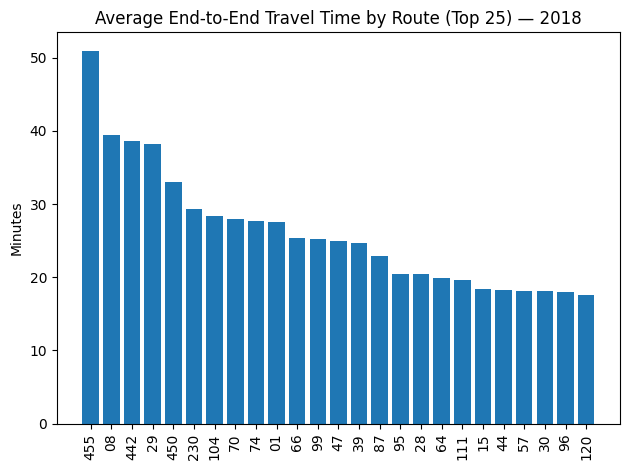

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

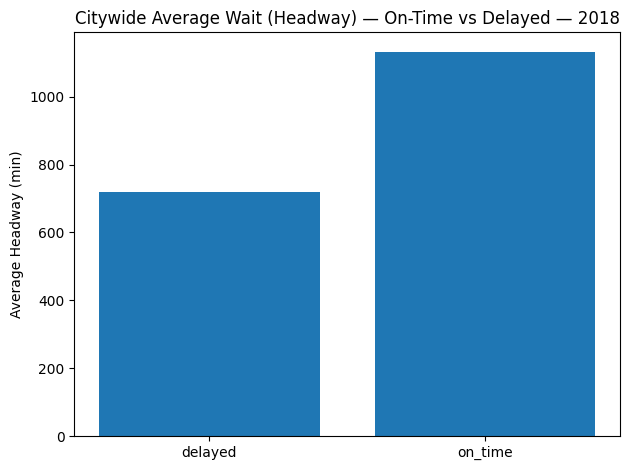

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Citywide average delay (2018): -266.53667190387904 min


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

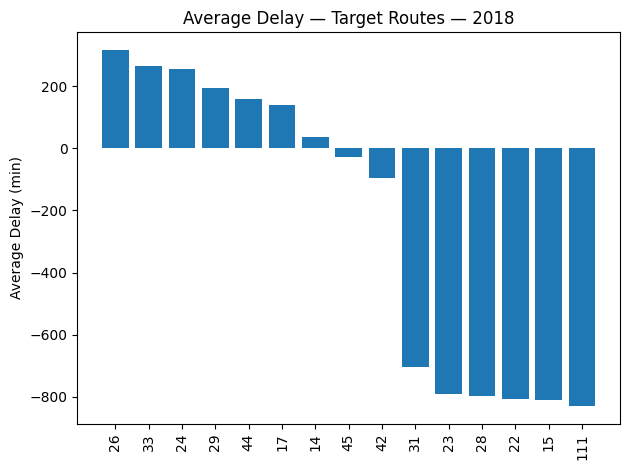

✅ Done. CSVs saved in ./results


In [1]:
# =========================
# MBTA Bus Reliability — 2018 (DuckDB, adaptive schema)
# =========================
!pip install -q duckdb gdown pyzipper

import os, glob, zipfile, shutil
import duckdb as ddb
import pandas as pd
import matplotlib.pyplot as plt

# ---- Config ----
YEAR = "2018"
FILE_ID = "1gGNsS2UMgJJLsDdBVAWwbflspPmQBWqT"  # Google Drive file id for 2018 ZIP
EXCLUDED_ROUTES = ('8007','7001','RAD','191','192','193','194','743','746_')
TARGET_ROUTES   = ("22","29","15","45","28","44","42","17","23","31","26","111","24","33","14")
ON_TIME_THRESHOLD_MIN = 0.5

TMP_DIR = f"/tmp/mbta_{YEAR}"
ZIP_PATH = f"/tmp/mbta_{YEAR}.zip"
DB_PATH  = f"/tmp/mbta_{YEAR}.duckdb"

# Clean temp & create dirs
if os.path.exists(TMP_DIR):
    shutil.rmtree(TMP_DIR)
os.makedirs(TMP_DIR, exist_ok=True)

# ---- Download & extract ZIP ----
import gdown
url = f"https://drive.google.com/uc?id={FILE_ID}"
print(f"Downloading {YEAR} ZIP…")
gdown.download(url, ZIP_PATH, quiet=False)

def extract_zip_with_fallback(zip_path, out_dir):
    try:
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(out_dir)
            return
    except (zipfile.BadZipFile, NotImplementedError):
        import pyzipper
        with pyzipper.AESZipFile(zip_path) as zf:
            zf.extractall(out_dir)

print(f"Extracting to {TMP_DIR} …")
extract_zip_with_fallback(ZIP_PATH, TMP_DIR)

csvs = glob.glob(os.path.join(TMP_DIR, "**", "*.csv"), recursive=True)
if not csvs:
    raise RuntimeError(f"No CSV files found in {TMP_DIR}")
print(f"Found {len(csvs)} CSV files for {YEAR}.")

# ---- DuckDB load ----
con = ddb.connect(DB_PATH)
con.execute("""
  CREATE OR REPLACE TABLE events AS
  SELECT * FROM read_csv_auto(?, union_by_name=true, header=true, filename=true);
""", [csvs])

# ---- Inspect available columns ----
cols = con.execute("PRAGMA table_info('events')").df()["name"].str.lower().tolist()
def pick(*candidates):
    for c in candidates:
        if c and c.lower() in cols:
            return c
    return None

# Flexible column mapping
route_col      = pick("route_id","route")
stop_col       = pick("stop_id","time_point_id","stop")
trip_col       = pick("trip_id","half_trip_id")
direction_col  = pick("direction_id","direction")
service_date_c = pick("service_date","date")
scheduled_col  = pick("scheduled","scheduled_time","sched_time")
actual_col     = pick("actual","actual_time","time","timestamp","departure_time","arrival_time")
delay_col_raw  = pick("delay_min","lateness","delay","earliness")  # 'earliness' will be negated

# Build SQL expressions safely
route_expr     = f"CAST({route_col} AS VARCHAR)" if route_col else "NULL"
stop_expr      = f"CAST({stop_col} AS VARCHAR)" if stop_col else "NULL"
trip_expr      = f"CAST({trip_col} AS VARCHAR)" if trip_col else "NULL"
direction_expr = f"CAST({direction_col} AS VARCHAR)" if direction_col else "NULL"
service_expr   = f"CAST({service_date_c} AS VARCHAR)" if service_date_c else "NULL"
sched_expr     = f"CAST({scheduled_col} AS VARCHAR)" if scheduled_col else "NULL"
actual_expr    = f"CAST({actual_col} AS VARCHAR)" if actual_col else "NULL"

# Delay expression:
#  - if 'delay_min' or 'lateness'/'delay' exists, use it;
#  - if only 'earliness' exists, delay_min = -earliness (early => negative delay);

def to_double(colname):
    # Strip thousands separators; try-cast to DOUBLE
    return f"TRY_CAST(REPLACE({colname}, ',', '') AS DOUBLE)"

delay_expr = "NULL"
if delay_col_raw:
    if delay_col_raw.lower() == "earliness":
        delay_expr = f"(-1.0 * {to_double(delay_col_raw)})"
    else:
        delay_expr = to_double(delay_col_raw)

# Some datasets already provide headway; detect it
headway_col = pick("headway","headway_min","avg_headway","wait_time")

# ---------- Build 'clean' view ----------
# Parse timestamps only if we have the needed columns; otherwise leave NULL and rely on provided headway
# --- Safe timestamp parsing that trims extra timestamps and offsets ---
# Extract only the first datetime part (up to first timezone or extra timestamp)
# --- Always define time_parse safely as a static SQL block ---
# --- Robust timestamp parsing: supports datetime, time-less dates, MM/DD/YYYY too ---
# Robust timestamp parsing:
# - pull just the first date/time via REGEXP_EXTRACT
# - NULLIF('', '') -> NULL
# - TRY_STRPTIME(...) returns NULL instead of raising on bad/empty strings
time_parse = """
    /* scheduled_dt */
    COALESCE(
      TRY_STRPTIME(NULLIF(REGEXP_EXTRACT(scheduled_raw, '\\d{4}-\\d{2}-\\d{2}[ T]\\d{2}:\\d{2}:\\d{2}'), ''), '%Y-%m-%d %H:%M:%S'),
      TRY_STRPTIME(NULLIF(REGEXP_EXTRACT(scheduled_raw, '\\d{4}-\\d{2}-\\d{2}[ T]\\d{2}:\\d{2}'),    ''), '%Y-%m-%d %H:%M'),
      TRY_STRPTIME(NULLIF(REGEXP_EXTRACT(scheduled_raw, '\\d{4}-\\d{2}-\\d{2}'),                     ''), '%Y-%m-%d'),
      TRY_STRPTIME(NULLIF(REGEXP_EXTRACT(scheduled_raw, '[0-9/]{10} \\d{2}:\\d{2}:\\d{2}'),          ''), '%m/%d/%Y %H:%M:%S'),
      TRY_STRPTIME(NULLIF(REGEXP_EXTRACT(scheduled_raw, '[0-9/]{10} \\d{2}:\\d{2}'),                 ''), '%m/%d/%Y %H:%M'),
      TRY_STRPTIME(NULLIF(REGEXP_EXTRACT(scheduled_raw, '[0-9/]{10}'),                               ''), '%m/%d/%Y')
    ) AS scheduled_dt,

    /* actual_dt */
    COALESCE(
      TRY_STRPTIME(NULLIF(REGEXP_EXTRACT(actual_raw, '\\d{4}-\\d{2}-\\d{2}[ T]\\d{2}:\\d{2}:\\d{2}'), ''), '%Y-%m-%d %H:%M:%S'),
      TRY_STRPTIME(NULLIF(REGEXP_EXTRACT(actual_raw, '\\d{4}-\\d{2}-\\d{2}[ T]\\d{2}:\\d{2}'),    ''), '%Y-%m-%d %H:%M'),
      TRY_STRPTIME(NULLIF(REGEXP_EXTRACT(actual_raw, '\\d{4}-\\d{2}-\\d{2}'),                     ''), '%Y-%m-%d'),
      TRY_STRPTIME(NULLIF(REGEXP_EXTRACT(actual_raw, '[0-9/]{10} \\d{2}:\\d{2}:\\d{2}'),          ''), '%m/%d/%Y %H:%M:%S'),
      TRY_STRPTIME(NULLIF(REGEXP_EXTRACT(actual_raw, '[0-9/]{10} \\d{2}:\\d{2}'),                 ''), '%m/%d/%Y %H:%M'),
      TRY_STRPTIME(NULLIF(REGEXP_EXTRACT(actual_raw, '[0-9/]{10}'),                               ''), '%m/%d/%Y')
    ) AS actual_dt
"""



clean_sql = f"""
CREATE OR REPLACE VIEW clean AS
WITH base AS (
  SELECT
    {route_expr}     AS route_id,
    {stop_expr}      AS stop_id,
    {trip_expr}      AS trip_raw,
    {direction_expr} AS direction_id,
    {service_expr}   AS service_date,
    {sched_expr}     AS scheduled_raw,
    {actual_expr}    AS actual_raw,
    {delay_expr}     AS delay_from_file,
    {"TRY_CAST(" + headway_col + " AS DOUBLE)" if headway_col else "NULL"} AS headway_from_file
  FROM events
),
ts AS (
  SELECT
    *,
    {time_parse}
  FROM base
),
enriched AS (
  SELECT
    route_id, stop_id, trip_raw, direction_id, service_date,
    scheduled_dt, actual_dt, headway_from_file,
    /* Prefer provided delay; else compute from timestamps if possible */
    COALESCE(
      delay_from_file,
      CASE WHEN scheduled_dt IS NOT NULL AND actual_dt IS NOT NULL
           THEN DATE_DIFF('minute', scheduled_dt, actual_dt)::DOUBLE
           ELSE NULL END
    ) AS delay_min
  FROM ts
),
sequenced AS (
  SELECT
    *,
    CASE
      WHEN trip_raw IS NOT NULL THEN trip_raw
      ELSE (
        COALESCE(route_id,'') || '-' || COALESCE(service_date,'') || '-' || COALESCE(direction_id,'') || '-t' ||
        CAST(
          ROW_NUMBER() OVER (
            PARTITION BY route_id, service_date, direction_id
            ORDER BY COALESCE(actual_dt, scheduled_dt)
          ) AS BIGINT
        )
      )
    END AS trip_key
  FROM enriched
)
SELECT *
FROM sequenced
WHERE route_id NOT IN ({",".join("'" + r + "'" for r in EXCLUDED_ROUTES)})
"""
con.execute(clean_sql)

# ---------- Q1: End-to-end travel time by route ----------
# If we don't have timestamps, this will return empty; that's OK (some sources only have headway/delay).
e2e_df = con.execute("""
  WITH trip_bounds AS (
    SELECT route_id, trip_key,
           MIN(actual_dt) AS t_min, MAX(actual_dt) AS t_max
    FROM clean
    WHERE actual_dt IS NOT NULL AND trip_key IS NOT NULL
    GROUP BY route_id, trip_key
  )
  SELECT route_id,
         AVG(DATE_DIFF('minute', t_min, t_max))::DOUBLE AS avg_e2e_min,
         COUNT(*) AS n_trips
  FROM trip_bounds
  GROUP BY route_id
  ORDER BY avg_e2e_min DESC
""").df()

if not e2e_df.empty:
    plt.figure()
    plt.bar(e2e_df["route_id"].head(25), e2e_df["avg_e2e_min"].head(25))
    plt.xticks(rotation=90)
    plt.ylabel("Minutes")
    plt.title(f"Average End-to-End Travel Time by Route (Top 25) — {YEAR}")
    plt.tight_layout()
    plt.show()
else:
    print("ℹ️ Skipping E2E plot — no usable timestamps to compute trip durations.")

# ---------- Q2: Average wait (headway) — on-time vs delayed ----------
if headway_col:
    # Use provided headway, then split by status using delay_min
    headway_df = con.execute(f"""
      WITH hw AS (
        SELECT
          CASE WHEN ABS(delay_min) <= {ON_TIME_THRESHOLD_MIN} THEN 'on_time' ELSE 'delayed' END AS status,
          headway_from_file AS headway_min
        FROM clean
        WHERE headway_from_file IS NOT NULL
      )
      SELECT status, AVG(headway_min) AS avg_headway_min
      FROM hw
      GROUP BY status
      ORDER BY status
    """).df()
else:
    # Compute headway from timestamps (if available)
    headway_df = con.execute(f"""
      WITH ordered AS (
        SELECT
          route_id, stop_id, actual_dt, delay_min,
          LAG(actual_dt) OVER (PARTITION BY route_id, stop_id ORDER BY actual_dt) AS prev_dt
        FROM clean
        WHERE actual_dt IS NOT NULL
      )
      SELECT
        CASE WHEN ABS(delay_min) <= {ON_TIME_THRESHOLD_MIN} THEN 'on_time' ELSE 'delayed' END AS status,
        AVG(DATE_DIFF('minute', prev_dt, actual_dt))::DOUBLE AS avg_headway_min
      FROM ordered
      WHERE prev_dt IS NOT NULL
      GROUP BY status
      ORDER BY status
    """).df()

if not headway_df.empty:
    plt.figure()
    plt.bar(headway_df["status"], headway_df["avg_headway_min"])
    plt.ylabel("Average Headway (min)")
    plt.title(f"Citywide Average Wait (Headway) — On-Time vs Delayed — {YEAR}")
    plt.tight_layout()
    plt.show()
else:
    print("ℹ️ Skipping headway plot — neither provided headway nor timestamps available.")

# ---------- Q3: Citywide average delay ----------
city_delay_df = con.execute("""
  SELECT AVG(delay_min)::DOUBLE AS citywide_avg_delay_min
  FROM clean
  WHERE delay_min IS NOT NULL
""").df()
print(f"Citywide average delay ({YEAR}): {city_delay_df['citywide_avg_delay_min'][0] if not city_delay_df.empty else 'NA'} min")

# ---------- Q4: Average delay for target routes ----------
targets_clause = "(" + ",".join(f"'{r}'" for r in TARGET_ROUTES) + ")"
targets_df = con.execute(f"""
  SELECT route_id, AVG(delay_min)::DOUBLE AS avg_delay_min
  FROM clean
  WHERE delay_min IS NOT NULL
    AND route_id IN {targets_clause}
  GROUP BY route_id
  ORDER BY avg_delay_min DESC
""").df()

if not targets_df.empty:
    plt.figure()
    plt.bar(targets_df["route_id"], targets_df["avg_delay_min"])
    plt.xticks(rotation=90)
    plt.ylabel("Average Delay (min)")
    plt.title(f"Average Delay — Target Routes — {YEAR}")
    plt.tight_layout()
    plt.show()
else:
    print("ℹ️ No target-route delay results — check that those routes exist in 2018 after exclusions.")

# ---------- Save outputs ----------
os.makedirs("results", exist_ok=True)
e2e_df.to_csv(f"results/e2e_{YEAR}.csv", index=False)
headway_df.to_csv(f"results/headway_on_time_vs_delayed_{YEAR}.csv", index=False)
city_delay_df.to_csv(f"results/citywide_avg_delay_{YEAR}.csv", index=False)
targets_df.to_csv(f"results/avg_delay_targets_{YEAR}.csv", index=False)
print("✅ Done. CSVs saved in ./results")
